In [1]:
# standard libraries
import importlib
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

from particles import resampling as rs

import md_lvm
importlib.reload(md_lvm)
import saem
importlib.reload(saem)

<module 'saem' from '/Users/francescacrucinio/Documents/MD_LVM/saem.py'>

In [2]:
# Load karate graph and find communities using Girvan-Newman
G = nx.karate_club_graph()

In [3]:
y = nx.to_numpy_array(G)
degree = np.array(G.degree)[:, 1]

In [4]:
z = np.zeros(y.shape[0])
for i in range(degree.size):
    if (degree[i] > 8):
        z[i] = 1

## SAEM

In [5]:
Niter = 1000
N = y.shape[0]
theta0 = np.array([0.5, 0.5, 0.5, 0.5, 0.5])
tol = 10**(-7)
X0 = np.random.binomial(1, 0.5, size = N)

In [6]:
# SAEM
z_iter = np.zeros([Niter, N])
s1_iter = np.zeros(Niter)
s2_iter = np.zeros((Niter, 4))
s3_iter = np.zeros((Niter, 4))
theta_saem = np.zeros((Niter, theta0.size))
n = 0
re = 1000
z_iter[n, :] = X0
theta_saem[n,:] = theta0
while ((n < Niter-1) & (re > tol)):
    n = n+1
    delta = 1/n
    z_iter[n, :] = saem.sbm_saem_proposal(y, z_iter[n-1, :], theta_saem[n-1,:])
    s1_update, s2_update, s3_update = saem.sbm_saem_sufficient_stat(z_iter[n, :], y)
    s1_iter[n] = s1_iter[n-1] + delta*(s1_update - s1_iter[n-1])
    s2_iter[n, :] = s2_iter[n-1, :] + delta*(s2_update - s2_iter[n-1, :])
    s3_iter[n, :] = s3_iter[n-1, :] + delta*(s3_update - s3_iter[n-1, :])
    theta_saem[n,:] = saem.sbm_saem_mle(s1_iter[n], s2_iter[n,:], s3_iter[n,:], N)
    re = np.max((theta_saem[n,:]-theta_saem[n-1,:])**2/theta_saem[n,:]**2)

In [7]:
n

368

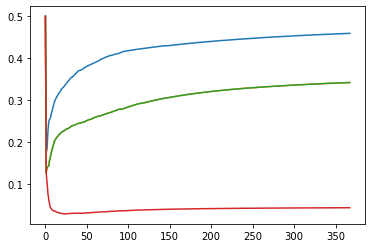

In [8]:
plt.plot(theta_saem[:n, 1:]);

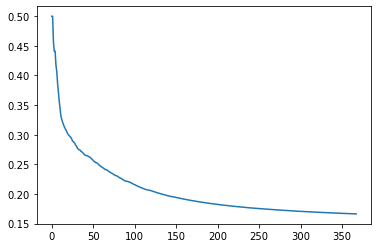

In [9]:
plt.plot(theta_saem[:n, 0]);

In [10]:
z_iter[n,:]

array([0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.])

## SMCs-LVM

In [11]:
gamma = 0.01

In [12]:
x_md = np.zeros((Niter, N))
theta_md = np.zeros((Niter, theta0.size))
n = 0
theta_md[n, :] = theta0
x_md[n, :] = X0
W = np.ones(N)/N
re = 1000

In [13]:
while ((n < Niter-1) & (re > tol)):
    n = n+1
    theta_md[n, 0] = theta_md[n-1,0]+gamma*np.sum(md_lvm.sbm_gradient_p(x_md[n-1,:].astype(int), theta_md[n-1, 0])*W)
    theta_md[n, 1:] = theta_md[n-1, 1:]+gamma*md_lvm.sbm_gradient_nu(x_md[n-1,:].astype(int), W, theta_md[n-1, :], y)
    re = np.max((theta_md[n,:]-theta_md[n-1,:])**2/theta_md[n,:]**2)
    if (n > 1):
        # resample
        ancestors = rs.resampling('stratified', W)
        x_md[n-1, :] = x_md[n-1, ancestors]
    # MCMC move
    x_md[n, :] = md_lvm.sbm_md_proposal(y, x_md[n-1,:].astype(int), theta_md[n-1, :], gamma, n)
    # reweight  
    logW = np.zeros(N)
    for i in range(N):
        logW[i] = (1-(1-gamma)**n)*saem.ll_sbm(theta_md[n-1, :], x_md[n, :].astype(int), y, i)+ np.log(0.5)*gamma*((1-gamma)**(n-1))
        if(n>1):
            logW[i] = logW[i] - (1-(1-gamma)**(n-1))*saem.ll_sbm(theta_md[n-2, :],x_md[n, :].astype(int), y, i) 
    W = rs.exp_and_normalise(logW)

In [14]:
n

226

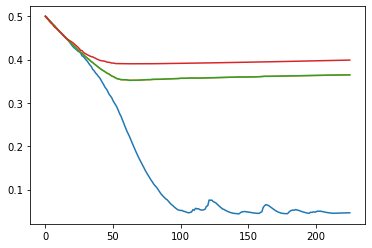

In [15]:
plt.plot(theta_md[:n, 1:]);

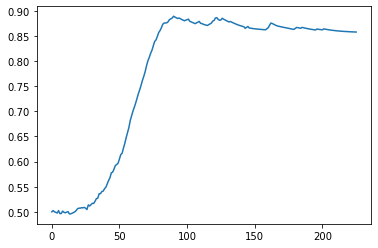

In [16]:
plt.plot(theta_md[:n, 0]);

In [17]:
x_md[n,:]

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.])

## Comparison

In [18]:
Niter = 1000
N = y.shape[0]
theta0 = np.array([0.5, 0.5, 0.5, 0.5, 0.5])
tol = 10**(-7)
X0 = np.random.binomial(1, 0.5, size = N)
gamma = 0.01

In [19]:
Nrep = 50
iter_md = np.zeros(Nrep)
times_md = np.zeros(Nrep)
ari_md = np.zeros((Nrep))
iter_saem = np.zeros(Nrep)
times_saem = np.zeros(Nrep)
ari_saem = np.zeros((Nrep))

In [20]:
for j in range(Nrep):
    # SAEM
    start = time.time()
    z_iter = np.zeros([Niter, N])
    s1_iter = np.zeros(Niter)
    s2_iter = np.zeros((Niter, 4))
    s3_iter = np.zeros((Niter, 4))
    theta_saem = np.zeros((Niter, theta0.size))
    n = 0
    re = 1000
    z_iter[n, :] = X0
    theta_saem[n,:] = theta0
    while ((n < Niter-1) & (re > tol)):
        n = n+1
        delta = 1/n
        z_iter[n, :] = saem.sbm_saem_proposal(y, z_iter[n-1, :], theta_saem[n-1,:])
        s1_update, s2_update, s3_update = saem.sbm_saem_sufficient_stat(z_iter[n, :], y)
        s1_iter[n] = s1_iter[n-1] + delta*(s1_update - s1_iter[n-1])
        s2_iter[n, :] = s2_iter[n-1, :] + delta*(s2_update - s2_iter[n-1, :])
        s3_iter[n, :] = s3_iter[n-1, :] + delta*(s3_update - s3_iter[n-1, :])
        theta_saem[n,:] = saem.sbm_saem_mle(s1_iter[n], s2_iter[n,:], s3_iter[n,:], N)
        re = np.max((theta_saem[n,:]-theta_saem[n-1,:])**2)
    end = time.time()
    times_saem[j] = end-start
    iter_saem[j] = n
    ari_saem[j] = saem.sbm_ari(z_iter[n,:], z)
    
    # SMCs-LVM
    start = time.time()
    x_md = np.zeros((Niter, N))
    theta_md = np.zeros((Niter, theta0.size))
    n = 0
    theta_md[n, :] = theta0
    x_md[n, :] = X0
    W = np.ones(N)/N
    re = 1000
    while ((n < Niter-1) & (re > tol)):
        n = n+1
        theta_md[n, 0] = theta_md[n-1,0]+gamma*np.sum(md_lvm.sbm_gradient_p(x_md[n-1,:].astype(int), theta_md[n-1, 0])*W)
        theta_md[n, 1:] = theta_md[n-1, 1:]+gamma*md_lvm.sbm_gradient_nu(x_md[n-1,:].astype(int), W, theta_md[n-1, :], y)
        re = np.max((theta_md[n,:]-theta_md[n-1,:])**2)
        if (n > 1):
            # resample
            ancestors = rs.resampling('stratified', W)
            x_md[n-1, :] = x_md[n-1, ancestors]
        # MCMC move
        x_md[n, :] = md_lvm.sbm_md_proposal(y, x_md[n-1,:].astype(int), theta_md[n-1, :], gamma, n)
        # reweight  
        logW = np.zeros(N)
        for i in range(N):
            logW[i] = (1-(1-gamma)**n)*saem.ll_sbm(theta_md[n-1, :], x_md[n, :].astype(int), y, i)+ np.log(0.5)*gamma*((1-gamma)**(n-1))
            if(n>1):
                logW[i] = logW[i] - (1-(1-gamma)**(n-1))*saem.ll_sbm(theta_md[n-2, :],x_md[n, :].astype(int), y, i) 
        W = rs.exp_and_normalise(logW)
    end = time.time()
    times_md[j] = end-start
    iter_md[j] = n
    ari_md[j] = saem.sbm_ari(x_md[n,:], z)

In [24]:
np.mean(iter_md)/np.mean(iter_saem)

1.5404131931859368

In [25]:
np.mean(times_md)/np.mean(times_saem)

3.949495384018209

In [23]:
np.mean(ari_md), np.mean(ari_saem)

(0.9775711756492437, 0.7848487718102267)